In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
from tqdm import tqdm
import torchsummary

In [2]:
trainset = torchvision.datasets.MNIST(root = "", train = True, download = True, transform=torchvision.transforms.ToTensor())
testset = torchvision.datasets.MNIST(root = "", train = False, download = True, transform=torchvision.transforms.ToTensor())
print('number of training data : ', len(trainset))
print('number of test data : ', len(testset))

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting MNIST/raw/train-images-idx3-ubyte.gz to MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/raw

number of training data :  60000
number of test data :  10000


In [3]:
train_loader = torch.utils.data.DataLoader(trainset,
                                          batch_size=32,
                                          shuffle=True,
                                          num_workers=1)
test_loader = torch.utils.data.DataLoader(testset,
                                          batch_size=32,
                                          shuffle=True,
                                          num_workers=1)

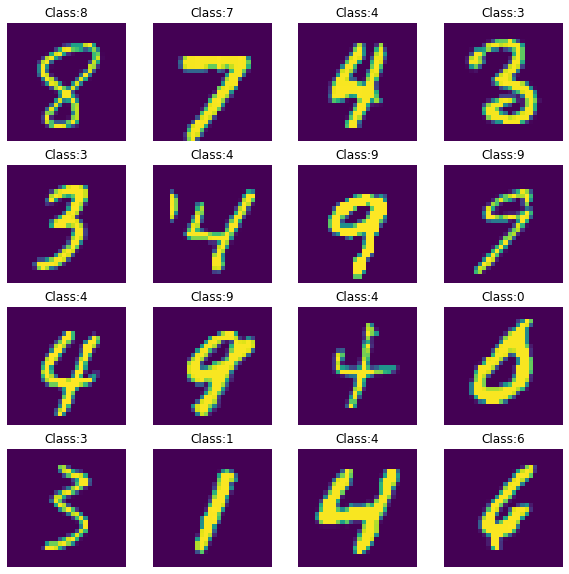

In [4]:
class_names = ['0','1','2','3','4','5','6','7','8','9']
plt.figure(figsize=(10, 10))
images, labels = next(iter(train_loader))
for i in range(16):
  ax = plt.subplot(4, 4, i + 1)
  img = images[i]
  img = (img - img.min())/(img.max() - img.min())
  plt.imshow(torch.squeeze(img.permute(1, 2, 0)).numpy())
  plt.title(f'Class:{class_names[labels[i]]}')
  plt.axis("off")

In [5]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP,self).__init__()
        self.linear = nn.Linear(784,256)
        self.relu = nn.ReLU()
        self.final = nn.Linear(256, 10)
    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.linear(x)
        x = self.relu(x)
        x = self.final(x)
        return x

In [6]:
#cost & loss 명시하기 & optimizer
gpu = torch.device("cuda")
model = MLP().to(gpu)
criterion = torch.nn.CrossEntropyLoss().to(gpu)
optimizer = torch.optim.SGD(model.parameters(), lr = 1e-4)

In [7]:
torchsummary.summary(model,(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]         200,960
              ReLU-2                  [-1, 256]               0
            Linear-3                   [-1, 10]           2,570
Total params: 203,530
Trainable params: 203,530
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.78
Estimated Total Size (MB): 0.78
----------------------------------------------------------------


In [9]:
epochs = 20
torch.cuda.empty_cache()    
train_losses = []
test_losses = []
train_acc = []
test_acc = []

for e in range(epochs):
    # training loop
    running_loss = 0       
    running_accuracy = 0 
    model.train()
    for _, data in enumerate(tqdm(train_loader)):
        # training phase            
        inputs, labels = data
        inputs = inputs.to(gpu).float()
        labels = labels.to(gpu).long()
        optimizer.zero_grad()  # reset gradient
        
        # forward        
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)            

        # backward
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        running_accuracy += torch.sum(preds == labels.data).detach().cpu().numpy()/inputs.size(0)


    model.eval()
    val_loss = 0
    val_accuracy = 0
    # validation loop
    with torch.no_grad():
        for _, data in enumerate(tqdm(test_loader)):                
            inputs, labels = data
            inputs = inputs.to(gpu).float()
            labels = labels.to(gpu).long()

            # forward
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            # evaluation metrics
            # loss
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_accuracy += torch.sum(preds == labels.data).detach().cpu().numpy()/inputs.size(0)

    # calculate mean for each batch
    train_losses.append(running_loss / len(train_loader))
    test_losses.append(val_loss / len(test_loader))
    train_acc.append(running_accuracy / len(train_loader))
    test_acc.append(val_accuracy / len(test_loader))
    print("Epoch:{}/{}..".format(e + 1, epochs),
            "Train Loss: {:.3f}..".format(running_loss / len(train_loader)),
            "Val Loss: {:.3f}..".format(val_loss / len(test_loader)),
            "Train Acc:{:.3f}..".format(running_accuracy / len(train_loader)),
            "Val Acc:{:.3f}..".format(val_accuracy / len(test_loader)))

history = {'train_loss': train_losses, 'val_loss': test_losses,
            'train_acc': train_acc, 'val_acc': test_acc}

100%|██████████| 313/313 [00:01<00:00, 185.37it/s]


Epoch:1/20.. Train Loss: 2.272.. Val Loss: 2.253.. Train Acc:0.195.. Val Acc:0.241..


100%|██████████| 313/313 [00:01<00:00, 178.59it/s]


Epoch:2/20.. Train Loss: 2.236.. Val Loss: 2.216.. Train Acc:0.283.. Val Acc:0.328..


100%|██████████| 313/313 [00:01<00:00, 180.95it/s]


Epoch:3/20.. Train Loss: 2.199.. Val Loss: 2.177.. Train Acc:0.387.. Val Acc:0.451..


100%|██████████| 313/313 [00:01<00:00, 185.72it/s]


Epoch:4/20.. Train Loss: 2.160.. Val Loss: 2.136.. Train Acc:0.485.. Val Acc:0.526..


100%|██████████| 313/313 [00:02<00:00, 149.17it/s]


Epoch:5/20.. Train Loss: 2.118.. Val Loss: 2.091.. Train Acc:0.546.. Val Acc:0.577..


100%|██████████| 313/313 [00:01<00:00, 181.89it/s]


Epoch:6/20.. Train Loss: 2.073.. Val Loss: 2.044.. Train Acc:0.586.. Val Acc:0.612..


100%|██████████| 313/313 [00:01<00:00, 185.01it/s]


Epoch:7/20.. Train Loss: 2.025.. Val Loss: 1.993.. Train Acc:0.620.. Val Acc:0.640..


100%|██████████| 313/313 [00:01<00:00, 186.19it/s]


Epoch:8/20.. Train Loss: 1.974.. Val Loss: 1.939.. Train Acc:0.646.. Val Acc:0.663..


100%|██████████| 313/313 [00:01<00:00, 163.79it/s]


Epoch:9/20.. Train Loss: 1.920.. Val Loss: 1.883.. Train Acc:0.667.. Val Acc:0.684..


100%|██████████| 313/313 [00:02<00:00, 137.15it/s]


Epoch:10/20.. Train Loss: 1.863.. Val Loss: 1.823.. Train Acc:0.685.. Val Acc:0.702..


100%|██████████| 313/313 [00:01<00:00, 179.48it/s]


Epoch:11/20.. Train Loss: 1.804.. Val Loss: 1.762.. Train Acc:0.699.. Val Acc:0.712..


100%|██████████| 313/313 [00:01<00:00, 182.75it/s]


Epoch:12/20.. Train Loss: 1.743.. Val Loss: 1.699.. Train Acc:0.712.. Val Acc:0.724..


100%|██████████| 313/313 [00:01<00:00, 182.82it/s]


Epoch:13/20.. Train Loss: 1.680.. Val Loss: 1.635.. Train Acc:0.722.. Val Acc:0.736..


100%|██████████| 313/313 [00:01<00:00, 183.66it/s]


Epoch:14/20.. Train Loss: 1.618.. Val Loss: 1.571.. Train Acc:0.732.. Val Acc:0.746..


100%|██████████| 313/313 [00:01<00:00, 181.23it/s]


Epoch:15/20.. Train Loss: 1.555.. Val Loss: 1.508.. Train Acc:0.740.. Val Acc:0.755..


100%|██████████| 313/313 [00:01<00:00, 180.27it/s]


Epoch:16/20.. Train Loss: 1.494.. Val Loss: 1.446.. Train Acc:0.748.. Val Acc:0.762..


100%|██████████| 313/313 [00:01<00:00, 179.95it/s]


Epoch:17/20.. Train Loss: 1.434.. Val Loss: 1.386.. Train Acc:0.756.. Val Acc:0.770..


100%|██████████| 313/313 [00:01<00:00, 183.52it/s]


Epoch:18/20.. Train Loss: 1.376.. Val Loss: 1.329.. Train Acc:0.765.. Val Acc:0.777..


100%|██████████| 313/313 [00:01<00:00, 181.20it/s]


Epoch:19/20.. Train Loss: 1.321.. Val Loss: 1.274.. Train Acc:0.772.. Val Acc:0.783..


100%|██████████| 313/313 [00:01<00:00, 182.58it/s]

Epoch:20/20.. Train Loss: 1.269.. Val Loss: 1.223.. Train Acc:0.778.. Val Acc:0.790..


In [10]:
### Test
model.eval()
y_pred = []
y_true = []
with torch.no_grad():
    for _, data in enumerate(tqdm(test_loader)):
        inputs, labels = data                    
        inputs = inputs.to(gpu).float()            
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)                        
        y_pred += list(preds.detach().cpu().numpy())
        y_true += list(labels.detach().numpy())

100%|██████████| 313/313 [00:01<00:00, 186.08it/s]


In [11]:
### 예측 리포트
from sklearn.metrics import classification_report, confusion_matrix
print('\n Classification report \n\n',
  classification_report(
      y_true,
      y_pred,
       target_names=class_names
      )
  )


 Classification report 

               precision    recall  f1-score   support

           0       0.81      0.96      0.88       980
           1       0.77      0.98      0.86      1135
           2       0.87      0.74      0.80      1032
           3       0.65      0.87      0.75      1010
           4       0.82      0.76      0.79       982
           5       0.95      0.32      0.48       892
           6       0.85      0.88      0.87       958
           7       0.83      0.87      0.85      1028
           8       0.75      0.71      0.73       974
           9       0.76      0.72      0.74      1009

    accuracy                           0.79     10000
   macro avg       0.81      0.78      0.77     10000
weighted avg       0.80      0.79      0.78     10000



(<matplotlib.legend.Legend at 0x7f49b85b6450>, None)

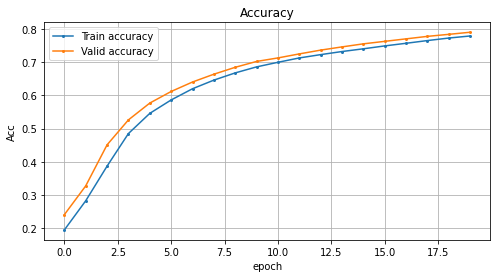

In [12]:
plt.figure(figsize = (8,4))
plt.plot(history['train_acc'],marker = 'o', ms = 2, label = "Train accuracy")
plt.plot(history['val_acc'],marker = 'o', ms = 2, label = "Valid accuracy")
plt.title(f'Accuracy');
plt.ylabel('Acc');
plt.xlabel('epoch')
plt.legend(), plt.grid()

(<matplotlib.legend.Legend at 0x7f4965511dd0>, None)

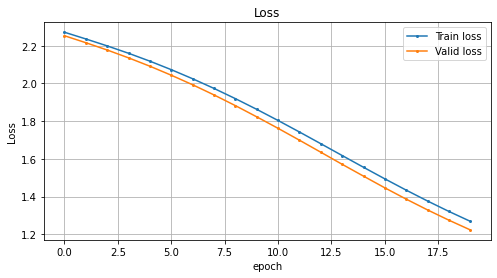

In [13]:
plt.figure(figsize = (8,4))
plt.plot(history['train_loss'],marker = 'o', ms = 2, label = "Train loss")
plt.plot(history['val_loss'],marker = 'o', ms = 2, label = "Valid loss")
plt.title(f'Loss');
plt.ylabel('Loss');
plt.xlabel('epoch')
plt.legend(), plt.grid()